# <font color='red'> Applied Machine Learning Project: 

# LendingClub Loan Repayment Prediction (Classification) 



### Data Source:

For this project I am going to explore publicly available data from [LendingClub.com](www.lendingclub.com). Lending Club connects people who need money (borrowers) with people who have money (investors). Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back. We will try to create a model that will help predict this.

link: https://www.kaggle.com/braindeadcoder/lending-club-data

### Dataset and features and target value. 

##### Features

- credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.


- purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").


- int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.


- installment: The monthly installments owed by the borrower if the loan is funded.


- log.annual.inc: The natural log of the self-reported annual income of the borrower.


- dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).


- fico: The FICO credit score of the borrower.


- days.with.cr.line: The number of days the borrower has had a credit line.


- revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).


- revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).


- inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.


- delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.


- pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).


##### Target value

- not.fully.paid - It represents whether the particular loan will be paid or not.



### Importing libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,f1_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
def null_percentage(df):
    '''
    input: dataframe
    output: Null percentage of columns in dataframe
    
    '''
    percent = df.isnull().sum()/len(df.index)*100
    df = pd.DataFrame(round(percent,2),columns=['null_percent'])
    
    
    return df[df['null_percent']!=0.00].sort_values('null_percent',ascending=False)

In [3]:
def cat_count(df):
    '''
    input: dataframe
    output: Give counts of number of categories in a column
    
    '''
    counts = {}
    cat_cols = df.select_dtypes(include=['object']).columns
    for i in range(len(cat_cols)):
        counts[cat_cols[i]] = len(df[cat_cols[i]].value_counts())
    
    return pd.DataFrame(data=counts.values(), index=counts.keys(),columns=['Categories Counts']).sort_values('Categories Counts',ascending=False)

In [4]:
def dummy_variables(df,cols):
    '''
    input: dataframe and categorical variable(to make dummy variable)
    output: dataframe with dummy variables
    
    '''
    for i in range(len(cols)):
        dummies = pd.get_dummies(df[cols[i]],drop_first=False)
        df = df.join(dummies)
        
    df.drop(cols,inplace=True,axis=1)
    return df

### Importing Data

In [5]:
loans = pd.read_csv('loan_data.csv')


In [6]:
drop_indices = np.random.choice(loans.index, int(loans.shape[0]*0.056), replace=False)
loans.iloc[drop_indices] = np.nan

### Exploratory Data Analysis (EDA)

In [7]:
loans.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

In [8]:
loans.head()


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1.0,debt_consolidation,0.1189,829.10,11.350407,19.48,737.0,5639.958333,28854.0,52.1,0.0,0.0,0.0,0.0
1,1.0,credit_card,0.1071,228.22,11.082143,14.29,707.0,2760.000000,33623.0,76.7,0.0,0.0,0.0,0.0
2,1.0,debt_consolidation,0.1357,366.86,10.373491,11.63,682.0,4710.000000,3511.0,25.6,1.0,0.0,0.0,0.0
3,1.0,debt_consolidation,0.1008,162.34,11.350407,8.10,712.0,2699.958333,33667.0,73.2,1.0,0.0,0.0,0.0
4,1.0,credit_card,0.1426,102.92,11.299732,14.97,667.0,4066.000000,4740.0,39.5,0.0,1.0,0.0,0.0


In [9]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9042 non-null float64
purpose              9042 non-null object
int.rate             9042 non-null float64
installment          9042 non-null float64
log.annual.inc       9042 non-null float64
dti                  9042 non-null float64
fico                 9042 non-null float64
days.with.cr.line    9042 non-null float64
revol.bal            9042 non-null float64
revol.util           9042 non-null float64
inq.last.6mths       9042 non-null float64
delinq.2yrs          9042 non-null float64
pub.rec              9042 non-null float64
not.fully.paid       9042 non-null float64
dtypes: float64(13), object(1)
memory usage: 1.0+ MB


In [10]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9042.000000,9042.000000,9042.000000,9042.000000,9042.000000,9042.000000,9042.000000,9.042000e+03,9042.000000,9042.000000,9042.000000,9042.000000,9042.000000
mean,0.804689,0.122635,319.122111,10.929997,12.641141,710.761889,4558.807357,1.695363e+04,46.839823,1.575868,0.164897,0.062707,0.159478
std,0.396462,0.026791,206.677444,0.613813,6.879172,37.893552,2493.739622,3.409799e+04,28.979601,2.192396,0.546594,0.263439,0.366141
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.555813,7.270000,682.000000,2820.000000,3.224250e+03,22.800000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.920527,12.700000,707.000000,4119.000000,8.651500e+03,46.200000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,433.235000,11.289832,18.000000,737.000000,5730.000000,1.821275e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,926.830000,14.180154,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


** Creating a heatmap of correlation between all the columns of loan dataset

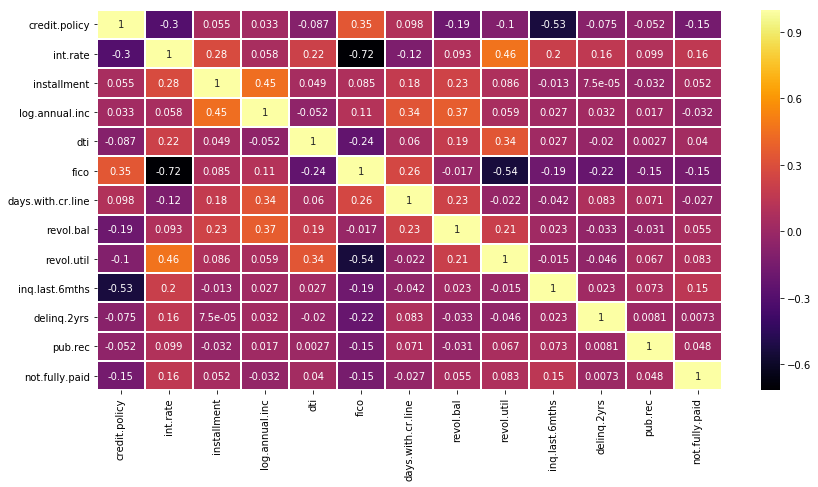

In [11]:
plt.figure(figsize=(14,7))
sns.heatmap(loans.corr(),annot=True,cmap='inferno',linewidths=1)

** Creating a histogram of two FICO distributions on top of each other, one for each credit.policy outcome.**



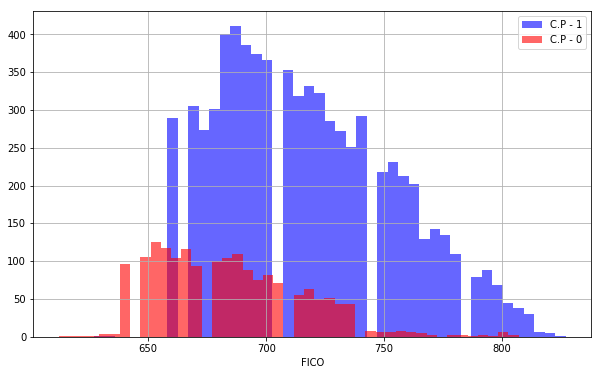

In [12]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(bins=45,color='blue',label='C.P - 1',alpha=0.6)
loans[loans['credit.policy']==0]['fico'].hist(bins=45,color='red',label='C.P - 0',alpha=0.6)
plt.xlabel("FICO")
plt.legend()

** Creating a histogram of two FICO distributions on top of each other, one for each No Fully Paid outcome.**



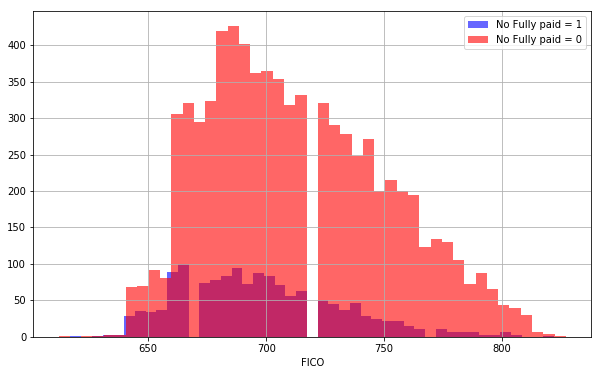

In [13]:
plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].hist(bins=45,color='blue',label='No Fully paid = 1',alpha=0.6)
loans[loans['not.fully.paid']==0]['fico'].hist(bins=45,color='red',label='No Fully paid = 0',alpha=0.6)

plt.xlabel("FICO")
plt.legend()

** Creating a countplot using seaborn showing the counts of loans by purpose, with the hue of not.fully.paid. ** 

Text(0, 0.5, 'Count of not.fully.paid')

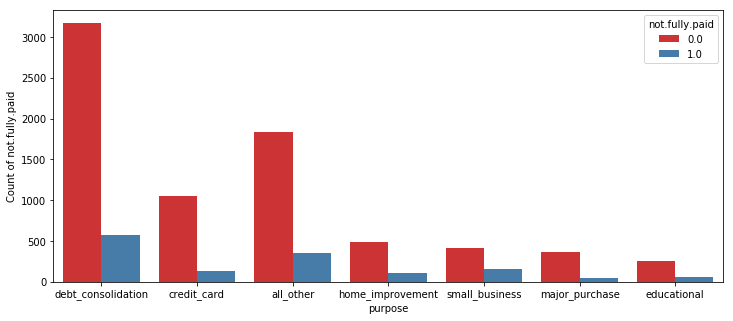

In [14]:
plt.figure(figsize=(12,5))
sns.countplot(x='purpose',hue="not.fully.paid",data=loans,palette='Set1')
plt.ylabel("Count of not.fully.paid")

** Let's see the trend between FICO score and interest rate. using lmplot **

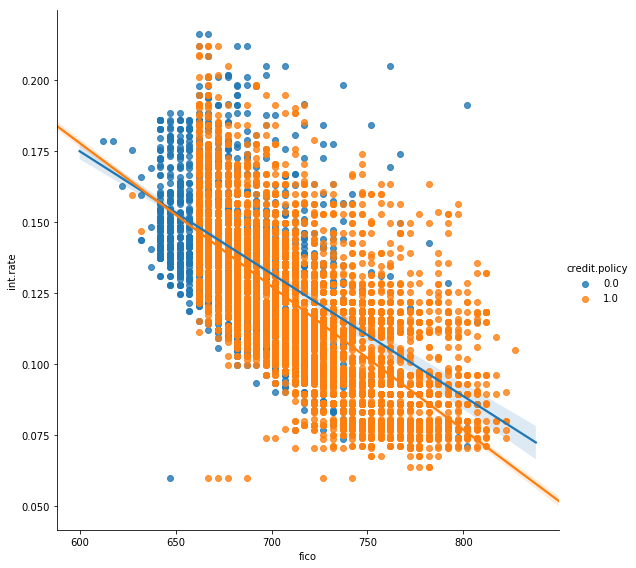

In [15]:
sns.lmplot(x='fico',y='int.rate',data=loans,hue='credit.policy',height=8)

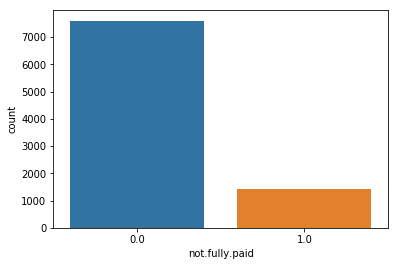

In [16]:
sns.countplot(loans['not.fully.paid'])

### Preprocessing
- Dealing with missing values

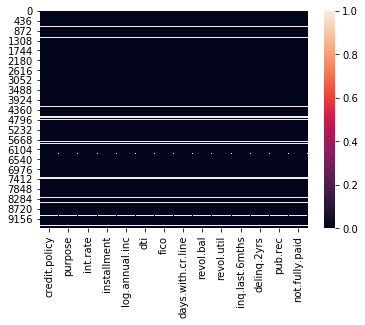

In [17]:
sns.heatmap(loans.isna())

In [18]:
null_percentage(loans)

,null_percent
credit.policy,5.6
purpose,5.6
int.rate,5.6
installment,5.6
log.annual.inc,5.6
dti,5.6
fico,5.6
days.with.cr.line,5.6
revol.bal,5.6
revol.util,5.6


In [19]:
loans.dropna(inplace=True)
null_percentage(loans)

,null_percent


- Treating Skewness

In [20]:
loans.skew()

credit.policy        -1.537383
int.rate              0.156043
installment           0.906445
log.annual.inc        0.021372
dti                   0.020196
fico                  0.474716
days.with.cr.line     1.162118
revol.bal            11.327828
revol.util            0.062014
inq.last.6mths        3.607234
delinq.2yrs           6.052588
pub.rec               5.135853
not.fully.paid        1.860468
dtype: float64

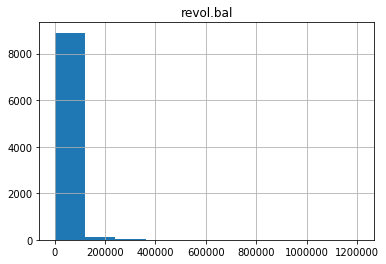

In [21]:
loans['revol.bal'].hist()
plt.title('revol.bal')
plt.show()

In [22]:
loans['revol.bal'] = np.log1p(loans['revol.bal'])

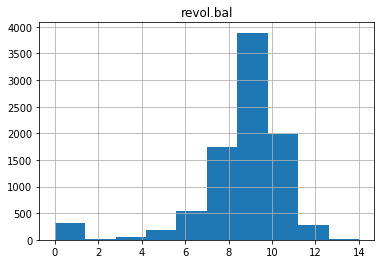

In [23]:
loans['revol.bal'].hist()
plt.title('revol.bal')
plt.show()

- Now converting Caterigorical columns

By creating Dummy Variables and Mapping

In [24]:
cat_count(loans)

,Categories Counts
purpose,7


In [25]:
loans['purpose'].value_counts()

debt_consolidation    3748
all_other             2194
credit_card           1192
home_improvement       589
small_business         582
major_purchase         413
educational            324
Name: purpose, dtype: int64

In [26]:
loans = dummy_variables(loans,['purpose'])
cat_count(loans)

,Categories Counts


- Undersampling

In [27]:
# separating classes into different datasets

paid_class = loans[loans["not.fully.paid"] == 0]
not_paid_class = loans[loans["not.fully.paid"] == 1]

In [28]:
# Resampling the normal class into 3:1 ratio with espect to fraudulent class

resampled_paid_class = paid_class.sample(n=int(len(not_paid_class)*1), random_state=1210)

In [29]:
# Concatenating the both classes in a single dataframe.

loans = pd.concat([not_paid_class,resampled_paid_class])

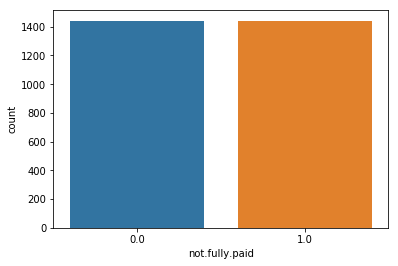

In [30]:
sns.countplot(loans['not.fully.paid'])

- Scaling

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
cols= ['int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec']

scaled_df = StandardScaler().fit_transform(loans[cols])

In [33]:
scaled_df = (pd.DataFrame(data=scaled_df, columns=cols)).reset_index()
scaled_df.drop('index',axis=1,inplace=True)

In [34]:
loans = loans.reset_index()

loans.drop('index',axis=1,inplace=True)

In [35]:
for col in cols:
    loans[col] = scaled_df[col]
    

### Splitting the data into train and test.

Now its time to split the data into a training set and a testing set!

** Using sklearn to split data into a training set and a testing set.**

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X = loans.drop('not.fully.paid',axis=1)
y = loans['not.fully.paid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [38]:
print("No of features after preprocessing: ",X.shape[1])

No of features after preprocessing:  19


### Classification Task:
- Apply two voting classifiers - one with hard voting and one with soft voting
- Apply any two models with bagging and any two models with pasting.
- Apply any two models with AdaBoost boosting
- Apply one model with gradient boosting
- Apply PCA on data and then apply all the models in project 1 again on data you get from PCA. Compare your results with results in project 1. You don't need to apply all the models twice. Just copy the result table from project 1, prepare a similar table for all the models after PCA and compare both tables. Does PCA help in getting better results?
- Apply deep learning models covered in class


# Voting Classifier
- Soft Voting

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [40]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
knn_clf = KNeighborsClassifier(7)
knn_clf.fit(X_train, y_train)
svm_clf = SVC(C = 10, probability = True)
svm_clf.fit(X_train, y_train)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('knn', knn_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (log_clf, knn_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.6096997690531177
KNeighborsClassifier 0.5496535796766744
SVC 0.6073903002309469
VotingClassifier 0.5981524249422633


In [41]:
predictions = voting_clf.predict(X_test)

In [42]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))

f1_scores_new = {}
f1_scores_new["Voting Classifier (soft)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.57      0.67      0.62       422
         1.0       0.63      0.53      0.57       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[284 138]
 [210 234]]

F-1 Score:  0.5735294117647058


- Hard Voting

In [43]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
knn_clf = KNeighborsClassifier(7)
knn_clf.fit(X_train, y_train)
svm_clf = SVC(C = 10, probability = True)
svm_clf.fit(X_train, y_train)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('knn', knn_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (log_clf, knn_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.6096997690531177
KNeighborsClassifier 0.5496535796766744
SVC 0.6073903002309469
VotingClassifier 0.605080831408776


In [44]:
predictions = voting_clf.predict(X_test)

In [45]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))

f1_scores_new["Voting Classifier (Hard)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.58      0.69      0.63       422
         1.0       0.64      0.53      0.58       444

   micro avg       0.61      0.61      0.61       866
   macro avg       0.61      0.61      0.60       866
weighted avg       0.61      0.61      0.60       866


CONFUSION MATRIX:
[[290 132]
 [210 234]]

F-1 Score:  0.5777777777777778


# Bagging 

- Bagging With Decision Tree Classifier

In [46]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


In [47]:
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=0.1,min_samples_split=0.4,random_state=1210)
bag_clf = BaggingClassifier(dt_clf, n_estimators=500, max_samples=100, bootstrap=True, random_state=0)

bag_clf.fit(X_train, y_train)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1210,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=None, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

In [48]:
predictions = bag_clf.predict(X_test)

In [49]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))

f1_scores_new["Decision Tree (Bagging)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       422
         1.0       0.00      0.00      0.00       444

   micro avg       0.49      0.49      0.49       866
   macro avg       0.24      0.50      0.33       866
weighted avg       0.24      0.49      0.32       866


CONFUSION MATRIX:
[[422   0]
 [444   0]]

F-1 Score:  0.0


- Bagging With Random Forest Classifier

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf_clf = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             max_features='auto',
                             min_samples_leaf=2,
                             min_samples_split=10,
                             n_estimators=200,
                             random_state=1210)

bag_clf = BaggingClassifier(rf_clf, n_estimators=500, max_samples=100, bootstrap=True, random_state=0)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1210, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=None, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

In [52]:
predictions = bag_clf.predict(X_test)

In [53]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))
f1_scores_new["Random Forest (Bagging)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.62      0.61       422
         1.0       0.62      0.59      0.61       444

   micro avg       0.61      0.61      0.61       866
   macro avg       0.61      0.61      0.61       866
weighted avg       0.61      0.61      0.61       866


CONFUSION MATRIX:
[[262 160]
 [181 263]]

F-1 Score:  0.6066897347174163


# Pasting

- Pasting With Logistic Regression

In [54]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression


In [55]:
log_clf = LogisticRegression(random_state=0)
bag_clf = BaggingClassifier(log_clf, bootstrap=False, random_state=0)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

In [56]:
predictions = bag_clf.predict(X_test)

In [57]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))
f1_scores_new["Logistic Regression (Pasting)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.66      0.62       422
         1.0       0.63      0.57      0.60       444

   micro avg       0.61      0.61      0.61       866
   macro avg       0.61      0.61      0.61       866
weighted avg       0.61      0.61      0.61       866


CONFUSION MATRIX:
[[277 145]
 [193 251]]

F-1 Score:  0.5976190476190476


- Pasting With Random Forest Classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
rf_clf = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             max_features='auto',
                             min_samples_leaf=2,
                             min_samples_split=10,
                             n_estimators=200,
                             random_state=1210)

bag_clf = BaggingClassifier(rf_clf, n_estimators=500, max_samples=100, bootstrap=False, random_state=0)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1210, verbose=0,
            warm_start=False),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=None, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

In [60]:
predictions = bag_clf.predict(X_test)

In [61]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))
f1_scores_new["Random Forest (Pasting)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.60      0.59       422
         1.0       0.61      0.60      0.61       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[254 168]
 [178 266]]

F-1 Score:  0.6059225512528474


# Adaboost

- Adaboost With Decision Tree Classifier

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


In [63]:
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=0.1,min_samples_split=0.4,random_state=1210)
ada_clf = AdaBoostClassifier(dt_clf, n_estimators= 500, learning_rate= 0.1)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1210,
            splitter='best'),
          learning_rate=0.1, n_estimators=500, random_state=None)

In [64]:
predictions = ada_clf.predict(X_test)

In [65]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))

f1_scores_new["Decision Tree (Adaboost)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57       422
         1.0       0.60      0.64      0.62       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[232 190]
 [159 285]]

F-1 Score:  0.6202393906420023


- Adaboost With Random Forest Classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
rf_clf = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             max_features='auto',
                             min_samples_leaf=2,
                             min_samples_split=10,
                             n_estimators=200,
                             random_state=1210)

ada_clf = AdaBoostClassifier(rf_clf, n_estimators= 500, learning_rate= 0.1)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1210, verbose=0,
            warm_start=False),
          learning_rate=0.1, n_estimators=500, random_state=None)

In [68]:
predictions = ada_clf.predict(X_test)

In [69]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))
f1_scores_new["Random Forest (Adaboost)"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.58       422
         1.0       0.61      0.62      0.61       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[244 178]
 [170 274]]

F-1 Score:  0.6116071428571429


# Gradient Boosting

- Gradient Boosting With Random Forest Classifier

In [70]:
from  sklearn.ensemble import GradientBoostingClassifier


In [71]:
gbrt = GradientBoostingClassifier(max_depth=3, n_estimators=500, learning_rate=0.01, random_state=42)

gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [72]:
predictions = gbrt.predict(X_test)

In [73]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))
f1_scores_new["Gradient Boosting"] = f1_score(y_test,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.60      0.62      0.61       422
         1.0       0.63      0.60      0.61       444

   micro avg       0.61      0.61      0.61       866
   macro avg       0.61      0.61      0.61       866
weighted avg       0.61      0.61      0.61       866


CONFUSION MATRIX:
[[262 160]
 [177 267]]

F-1 Score:  0.6130884041331803


# PCA

In [74]:
from sklearn.decomposition import PCA

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [76]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [77]:
finalDf.head()

,principal component 1,principal component 2,not.fully.paid
0,-0.987381,1.564399,1.0
1,0.383541,-0.457098,1.0
2,-1.478407,-1.496520,1.0
3,1.057543,1.521284,1.0
4,-1.452508,-1.170521,1.0


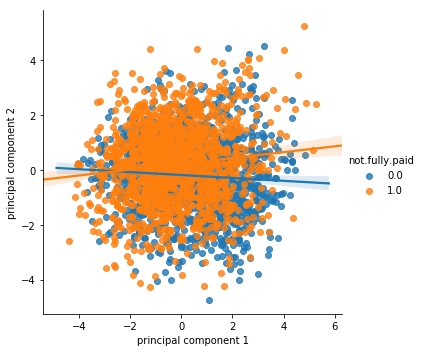

In [78]:
sns.lmplot(x='principal component 1',y='principal component 2',hue='not.fully.paid',data=finalDf)

In [79]:
X_2D = finalDf.drop('not.fully.paid',axis=1)
y_2D = finalDf['not.fully.paid']

X_train_2D, X_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, y_2D, test_size=0.30, random_state=10)

## 1. Training a Logistic Regression Model


** Import LogisticRegressionr**

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
lr = LogisticRegression(random_state=1210)
lr.fit(X_train_2D,y_train_2D)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1210, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Predictions and Evaluation of Logistic Regression
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [82]:
predictions = lr.predict(X_test_2D)

In [83]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test,predictions))

print("\nF-1 Score: ",f1_score(y_test,predictions))

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       422
         1.0       0.61      0.62      0.61       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[245 177]
 [169 275]]

F-1 Score:  0.6138392857142857


### Tuning Logistic Regression Model Parameters


In [84]:
lr = LogisticRegression(random_state=1210)

In [85]:
grid_list = {"C": np.arange(1, 15, 2),
             "max_iter": np.arange(25, 500, 50),
             "penalty": np.array(["l1","l2"]),
             "random_state": [1210] }
 
grid_search = GridSearchCV(lr, param_grid = grid_list, n_jobs = -1, cv = 5, scoring = 'f1',verbose=1) 


In [86]:
grid_search.fit(X_train_2D,y_train_2D)


Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 677 out of 700 | elapsed:    4.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1210, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([ 1,  3,  5,  7,  9, 11, 13]), 'max_iter': array([ 25,  75, 125, 175, 225, 275, 325, 375, 425, 475]), 'penalty': array(['l1', 'l2'], dtype='<U2'), 'random_state': [1210]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [87]:
print("Logistic Regression Best Score :",grid_search.best_score_)
print("Logistic Regression Best Parameters :",grid_search.best_params_)
best_scores = {}
best_scores["Logistic Regression"] = grid_search.best_score_

Logistic Regression Best Score : 0.592570044207561
Logistic Regression Best Parameters : {'C': 1, 'max_iter': 25, 'penalty': 'l2', 'random_state': 1210}


In [88]:
lr = LogisticRegression(C= 1, max_iter=25,penalty='l1',random_state=1210)
lr.fit(X_train_2D,y_train_2D)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=25, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1210, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Predictions and Evaluation of Tuned Logistic Regression Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [89]:
predictions = lr.predict(X_test_2D)

In [90]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))

f1_scores = {}
f1_scores["Logistic Regression"] = f1_score(y_test_2D,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       422
         1.0       0.61      0.62      0.62       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[245 177]
 [168 276]]

F-1 Score:  0.6153846153846154


## 2. Training a Decision Tree Model


** Import DecisionTreeClassifier**

In [91]:
from sklearn.tree import DecisionTreeClassifier

In [92]:
dtc = DecisionTreeClassifier(random_state=1210)
dtc.fit(X_train_2D,y_train_2D)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1210,
            splitter='best')

### Predictions and Evaluation of Decision Tree
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [93]:
predictions = dtc.predict(X_test_2D)

In [94]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51       422
         1.0       0.53      0.53      0.53       444

   micro avg       0.52      0.52      0.52       866
   macro avg       0.52      0.52      0.52       866
weighted avg       0.52      0.52      0.52       866


CONFUSION MATRIX:
[[214 208]
 [209 235]]

F-1 Score:  0.5298759864712513


### Tuning Decision Tree Parameters


In [95]:
dt = DecisionTreeClassifier()

In [96]:
grid_list = {"max_depth" : np.array([10,20,40,80,100,120]),
             "min_samples_leaf" : np.array([0.1,0.2,0.3,0.4,0.5]), 
             "min_samples_split" : np.array([0.1,0.2,0.4,0.6,0.8,0.9]),
             "random_state" : [1210]}
 
grid_search = GridSearchCV(dt, param_grid = grid_list, n_jobs = -1, cv = 5, scoring = 'f1',verbose=1) 


In [97]:
grid_search.fit(X_train_2D,y_train_2D)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([ 10,  20,  40,  80, 100, 120]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'min_samples_split': array([0.1, 0.2, 0.4, 0.6, 0.8, 0.9]), 'random_state': [1210]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [98]:
print("Decision Tree Best Score :",grid_search.best_score_)
print("Decision Tree Best Parameters :",grid_search.best_params_)

best_scores["Decision Tree"] = grid_search.best_score_

Decision Tree Best Score : 0.6048409385936553
Decision Tree Best Parameters : {'max_depth': 10, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4, 'random_state': 1210}


In [99]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=0.1,min_samples_split=0.4,random_state=1210)
dt.fit(X_train_2D,y_train_2D)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1210,
            splitter='best')

### Predictions and Evaluation of Tuned Decision Tree Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [100]:
predictions = dt.predict(X_test_2D)

In [101]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))

f1_scores["Decision Tree"] = f1_score(y_test_2D,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.60      0.52      0.56       422
         1.0       0.59      0.67      0.63       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.59      0.59       866
weighted avg       0.60      0.60      0.59       866


CONFUSION MATRIX:
[[220 202]
 [148 296]]

F-1 Score:  0.6284501061571125


## Training the Random Forest model
** Import RandomForestClassifier**

In [102]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
rfc = RandomForestClassifier(random_state=1210)
rfc.fit(X_train_2D,y_train_2D)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1210, verbose=0,
            warm_start=False)

### Predictions and Evaluation of  Random Forest 


In [104]:
predictions = rfc.predict(X_test_2D)

In [105]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.53      0.59      0.55       422
         1.0       0.56      0.50      0.53       444

   micro avg       0.54      0.54      0.54       866
   macro avg       0.54      0.54      0.54       866
weighted avg       0.54      0.54      0.54       866


CONFUSION MATRIX:
[[247 175]
 [223 221]]

F-1 Score:  0.5261904761904762


### Tuning Random Forest Parameters


In [106]:
rfc = RandomForestClassifier(random_state=1210)

In [107]:
grid_list = {'n_estimators': [50,100,150,200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10,30,60,80],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
               "random_state": [1210]}
     
grid_search = GridSearchCV(rfc, param_grid = grid_list, n_jobs = -1, cv = 3, scoring = 'f1',verbose=1) 


In [108]:
grid_search.fit(X_train_2D,y_train_2D)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1210, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 30, 60, 80], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'random_state': [1210]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [109]:
print("Random Forest Best Score :",grid_search.best_score_)
print("Random Forest Best Parameters :",grid_search.best_params_)

best_scores["Random Forest"] = grid_search.best_score_

Random Forest Best Score : 0.5762836053940139
Random Forest Best Parameters : {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 1210}


In [110]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             max_features='auto',
                             min_samples_leaf=2,
                             min_samples_split=10,
                             n_estimators=200,
                             random_state=1210)
rfc.fit(X_train_2D,y_train_2D)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1210, verbose=0,
            warm_start=False)

### Predictions and Evaluation of Tuned Random Forest Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [111]:
predictions = rfc.predict(X_test_2D)

In [112]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))

f1_scores["Random Forest"] = f1_score(y_test_2D,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.57      0.56      0.57       422
         1.0       0.59      0.60      0.60       444

   micro avg       0.58      0.58      0.58       866
   macro avg       0.58      0.58      0.58       866
weighted avg       0.58      0.58      0.58       866


CONFUSION MATRIX:
[[237 185]
 [177 267]]

F-1 Score:  0.5959821428571428


## Training a K-Nearest Neighbors Model


** Import KNeighborsClassifier**

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [114]:
knn = KNeighborsClassifier()

In [115]:
knn.fit(X_train_2D,y_train_2D)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

### Predictions and Evaluation of K-Nearest Neighbors Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [116]:
predictions = knn.predict(X_test_2D)

In [117]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.54      0.55      0.55       422
         1.0       0.57      0.56      0.56       444

   micro avg       0.56      0.56      0.56       866
   macro avg       0.56      0.56      0.56       866
weighted avg       0.56      0.56      0.56       866


CONFUSION MATRIX:
[[233 189]
 [196 248]]

F-1 Score:  0.5629965947786605


### Tuning Random Forest Parameters


In [118]:
knn = KNeighborsClassifier()

In [119]:
grid_list = {'n_neighbors':[3,5,7,9],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}
     
grid_search = GridSearchCV(knn, param_grid = grid_list, n_jobs = -1, cv = 3, scoring = 'f1',verbose=1) 


In [120]:
grid_search.fit(X_train_2D,y_train_2D)


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:    3.2s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 9], 'leaf_size': [1, 2, 3, 5], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [121]:
print("KNN Best Score :",grid_search.best_score_)
print("KNN Best Parameters :",grid_search.best_params_)

best_scores["KNN"] = grid_search.best_score_

KNN Best Score : 0.5510315193450156
KNN Best Parameters : {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'weights': 'uniform'}


In [122]:
knn = KNeighborsClassifier(algorithm='auto',
                           leaf_size=1,
                           n_neighbors=9,
                           weights='uniform')
knn.fit(X_train_2D,y_train_2D)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

### Predictions and Evaluation of Tuned Random Forest Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [123]:
predictions = knn.predict(X_test_2D)

In [124]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))

f1_scores["KNN"] = f1_score(y_test_2D,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.55      0.56      0.56       422
         1.0       0.58      0.57      0.57       444

   micro avg       0.56      0.56      0.56       866
   macro avg       0.56      0.56      0.56       866
weighted avg       0.56      0.56      0.56       866


CONFUSION MATRIX:
[[236 186]
 [192 252]]

F-1 Score:  0.5714285714285713


## Training a Linear SVC Model


** Import LinearSVC**

In [125]:
from sklearn.svm import LinearSVC

In [126]:
lsvc =LinearSVC(random_state=1210)
lsvc.fit(X_train_2D,y_train_2D)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1210, tol=0.0001,
     verbose=0)

### Predictions and Evaluation of Linear SVC Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [127]:
predictions = lsvc.predict(X_test_2D)

In [128]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       422
         1.0       0.61      0.62      0.62       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[245 177]
 [168 276]]

F-1 Score:  0.6153846153846154


### Tuning Linear SVC Parameters


In [129]:
lsvc = LinearSVC(random_state=1210)

In [130]:
grid_list = {'C': [6,7,8,9,10,11,12],
            'max_iter' : [1000,2000,3000],
            "random_state": [1210]}
    

grid_search = GridSearchCV(lsvc, param_grid = grid_list, n_jobs = -1, cv = 5, scoring = 'f1',verbose=1) 


In [131]:
grid_search.fit(X_train_2D,y_train_2D)


Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  82 out of 105 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1210, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [6, 7, 8, 9, 10, 11, 12], 'max_iter': [1000, 2000, 3000], 'random_state': [1210]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [132]:
print("Linear SVC Score :",grid_search.best_score_)
print("Linear SVC Best Parameters :",grid_search.best_params_)

best_scores["Linear SVC"] = grid_search.best_score_

Linear SVC Score : 0.592278013818704
Linear SVC Best Parameters : {'C': 8, 'max_iter': 2000, 'random_state': 1210}


In [133]:
lsvc = LinearSVC(C=8,max_iter=3000,random_state=1210)
lsvc.fit(X_train_2D,y_train_2D)

LinearSVC(C=8, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=3000,
     multi_class='ovr', penalty='l2', random_state=1210, tol=0.0001,
     verbose=0)

### Predictions and Evaluation of Tuned Linear SVC Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [134]:
predictions = lsvc.predict(X_test_2D)

In [135]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))

f1_scores["Linear SVC"] = f1_score(y_test_2D,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       422
         1.0       0.61      0.62      0.62       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[245 177]
 [168 276]]

F-1 Score:  0.6153846153846154


## Training a Kernalized SVC Model


** Import SVC**

In [136]:
from sklearn.svm import SVC

In [137]:
ksvc = SVC(kernel='rbf',random_state=1210)
ksvc.fit(X_train_2D,y_train_2D)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1210,
  shrinking=True, tol=0.001, verbose=False)

### Predictions and Evaluation of Linear SVC Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [138]:
predictions = ksvc.predict(X_test_2D)

In [139]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.60      0.52      0.55       422
         1.0       0.59      0.67      0.63       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.59      0.59       866
weighted avg       0.60      0.60      0.59       866


CONFUSION MATRIX:
[[218 204]
 [146 298]]

F-1 Score:  0.6300211416490487


### Tuning Kernal SVC Parameters


In [140]:
ksvc = SVC(kernel='rbf',random_state=1210)

In [141]:
grid_list = {'C': [1,2,3,4,5,6,7],
             'gamma': [0.5,1,2,3,5],
             "random_state": [1210]}
    
    
grid_search = GridSearchCV(ksvc, param_grid = grid_list, n_jobs = -1, cv = 5, scoring = 'f1',verbose=1) 

In [142]:
grid_search.fit(X_train_2D,y_train_2D)


Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 out of 175 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1210,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 2, 3, 4, 5, 6, 7], 'gamma': [0.5, 1, 2, 3, 5], 'random_state': [1210]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [143]:
print("Kernal SVC Score :",grid_search.best_score_)
print("Kernal SVC Best Parameters :",grid_search.best_params_)

best_scores["Kernal SVC"] = grid_search.best_score_

Kernal SVC Score : 0.6087108025037854
Kernal SVC Best Parameters : {'C': 1, 'gamma': 0.5, 'random_state': 1210}


In [144]:
ksvc = SVC(kernel='rbf', C=1,gamma=0.5,random_state=1210)
ksvc.fit(X_train_2D,y_train_2D)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=1210, shrinking=True,
  tol=0.001, verbose=False)

### Predictions and Evaluation of Tuned Linear SVC Model
**Creating predictions from the test set and creating a classification report and confusion matrix.**

In [145]:
predictions = ksvc.predict(X_test_2D)

In [146]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))

f1_scores["Kernal SVC"] = f1_score(y_test_2D,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.60      0.52      0.55       422
         1.0       0.59      0.67      0.63       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.59      0.59       866
weighted avg       0.60      0.60      0.59       866


CONFUSION MATRIX:
[[218 204]
 [146 298]]

F-1 Score:  0.6300211416490487


# Deep Learning

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.utils import np_utils,to_categorical



Using TensorFlow backend.


In [148]:
y_train_CAT = to_categorical(y_train)
y_test_CAT = to_categorical(y_test)

In [149]:
X_train.shape

(2018, 19)

In [150]:
# step 1: build the model
model = Sequential()
model.add(Dense(32, input_dim = 19, activation='relu'))
model.add(Dense(2, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [151]:
# step 2: compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# step 3: train the model
history = model.fit(X_train, y_train_CAT, batch_size= 64, epochs=30,validation_split=0.1)

Train on 1816 samples, validate on 202 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1816/1816 [==============================] - 0s 248us/sample - loss: 0.7681 - acc: 0.4626 - val_loss: 0.7436 - val_acc: 0.4950
Epoch 2/30
1816/1816 [==============================] - 0s 42us/sample - loss: 0.6996 - acc: 0.5457 - val_loss: 0.6968 - val_acc: 0.5644
Epoch 3/30
1816/1816 [==============================] - 0s 43us/sample - loss: 0.6742 - acc: 0.5589 - val_loss: 0.6779 - val_acc: 0.5743
Epoch 4/30
1816/1816 [==============================] - ETA: 0s - loss: 0.6572 - acc: 0.590 - 0s 45us/sample - loss: 0.6618 - acc: 0.5870 - val_loss: 0.6685 - val_acc: 0.5941
Epoch 5/30
1816/1816 [==============================] - 0s 42us/sample - loss: 0.6550 - acc: 0.6024 - val_loss: 0.6633 - val_acc: 0.6238
Epoch 6/30
1816/1816 [==============================] - 0s 44us/sample - loss: 0.6503 - acc: 0.6057 - val_loss: 0.6617 - val_acc: 0.6188
Epoch 7/30
1816/1816 [======================

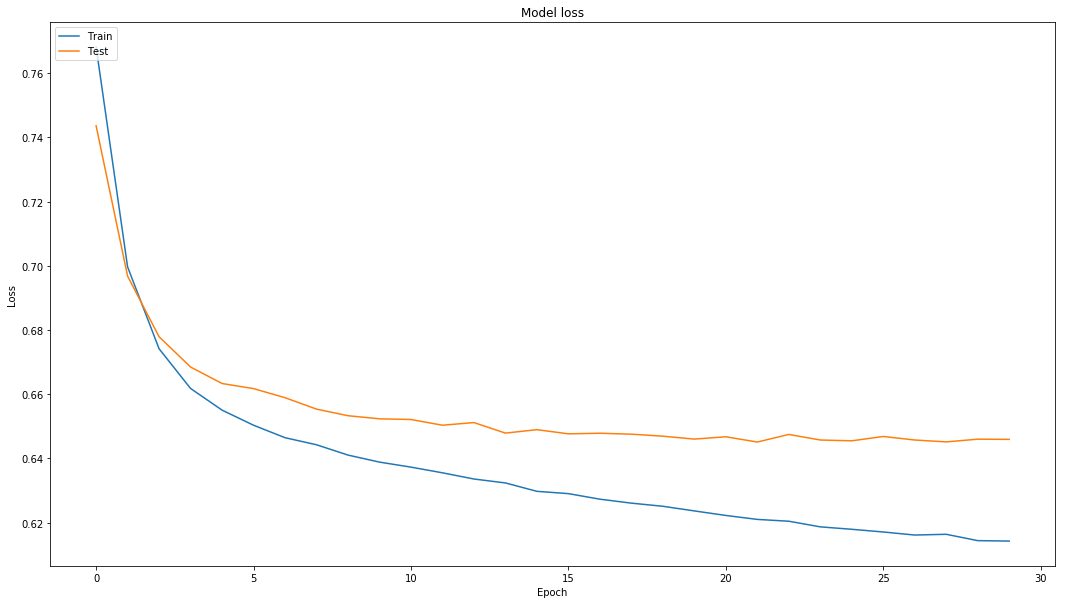

In [152]:
plt.figure(figsize=(18,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [153]:
predictions = model.predict(X_test)
data = pd.DataFrame(data=predictions,columns=['class1','class2'])

In [154]:
def target(class1,class2):
    if class1 > 0.5:
        return 0
    elif class2 > 0.5:
        return 1

data['target']=data.apply(lambda row: target(row['class1'], row['class2']), axis=1)
predictions = data['target']

In [155]:
print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test_2D,predictions))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test_2D,predictions))

print("\nF-1 Score: ",f1_score(y_test_2D,predictions))

f1_scores_new["Deep Learning"] = f1_score(y_test_2D,predictions)

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

         0.0       0.58      0.65      0.61       422
         1.0       0.63      0.55      0.59       444

   micro avg       0.60      0.60      0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.60      0.60      0.60       866


CONFUSION MATRIX:
[[275 147]
 [198 246]]

F-1 Score:  0.5878136200716846


In [156]:
score_df = (pd.DataFrame(data=best_scores.values(),columns=['Best Score'],index=best_scores.keys())).sort_values(by='Best Score',ascending=False).reset_index()
score_df.columns = ['Model','Best Score']

f1_df= (pd.DataFrame(data=f1_scores.values(),columns=['F1 Score'],index=f1_scores.keys())).sort_values(by='F1 Score',ascending=False).reset_index()
f1_df.columns = ['Model','f1 Score']

f1_df_new= (pd.DataFrame(data=f1_scores_new.values(),columns=['F1 Score'],index=f1_scores_new.keys())).sort_values(by='F1 Score',ascending=False).reset_index()
f1_df_new.columns = ['Model','f1 Score']

In [157]:
#Model Score Comparison
scr = pd.read_csv('score_df.csv')
scr.drop(['Unnamed: 0'],axis=1,inplace=True)
scr.columns = ['Model','Model Score (Before PCA)']
scr.set_index(['Model'],inplace=True)

score_df.columns = ['Model','Model Score (After PCA)']
score_df.set_index(['Model'],inplace=True)
score_comparison = scr.join(score_df)


#f1 score Comparison
f1_ = pd.read_csv('f1_df.csv')
f1_.drop(['Unnamed: 0'],axis=1,inplace=True)
f1_.columns = ['Model','F1 Score (Before PCA)']
f1_.set_index(['Model'],inplace=True)

f1_df.columns = ['Model','F1 Score (After PCA)']
f1_df.set_index(['Model'],inplace=True)
f1_comparison = scr.join(f1_df)

In [158]:
score_comparison

,Model Score (Before PCA),Model Score (After PCA)
Model,,
Decision Tree,0.681876,0.604841
Random Forest,0.624603,0.576284
Kernal SVC,0.623103,0.608711
Linear SVC,0.617043,0.592278
Logistic Regression,0.616754,0.592570
KNN,0.579454,0.551032


- PCA is reducing the model score

In [159]:
f1_comparison

,Model Score (Before PCA),F1 Score (After PCA)
Model,,
Decision Tree,0.681876,0.628450
Random Forest,0.624603,0.595982
Kernal SVC,0.623103,0.630021
Linear SVC,0.617043,0.615385
Logistic Regression,0.616754,0.615385
KNN,0.579454,0.571429


- PCA is reducing the F1 score

- PCS is reducing the score for every model 

In [160]:
f1_df_new

,Model,f1 Score
0,Decision Tree (Adaboost),0.620239
1,Gradient Boosting,0.613088
2,Random Forest (Adaboost),0.611607
3,Random Forest (Bagging),0.606690
4,Random Forest (Pasting),0.605923
5,Logistic Regression (Pasting),0.597619
6,Deep Learning,0.587814
7,Voting Classifier (Hard),0.577778
8,Voting Classifier (soft),0.573529
9,Decision Tree (Bagging),0.000000


## Classification:

- Describe Dataset 
Total rows - 9578
Total columns – 14 (No of features increased to 19 after Feature Engineering)


- Missing Data- As out dataset is not having any missing values so we are randomly creating it dealing with the missing values


- Reason for using Standard Scaler – because most of the data is normally distributed and the Standard scale will scale all features such that the distribution is centered around 0, with a standard deviation of 1. If the data is not normally distributed and standard deviation is very small then Min-Max is better but these conditions are not fulfilling in our data so that is why we are not using this scaling.


- Why F1 score- As in our data both false negatives and false positives to be less are important because:
we don’t want defaulters should be given a loan so -> we want less false negatives 
And for any company to be profitably they don’t want the one who can give money back should be classifies as not fully paid customers so in that case we want the false positives to be also less.
Both recall and precision are important and should be high. Both type1 error and type11 error should be least so we are taking F1 score as decision maker as its is a harmonic mean of both and considers both the score function. F1 Score is better measure as it seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).


# Final Tree

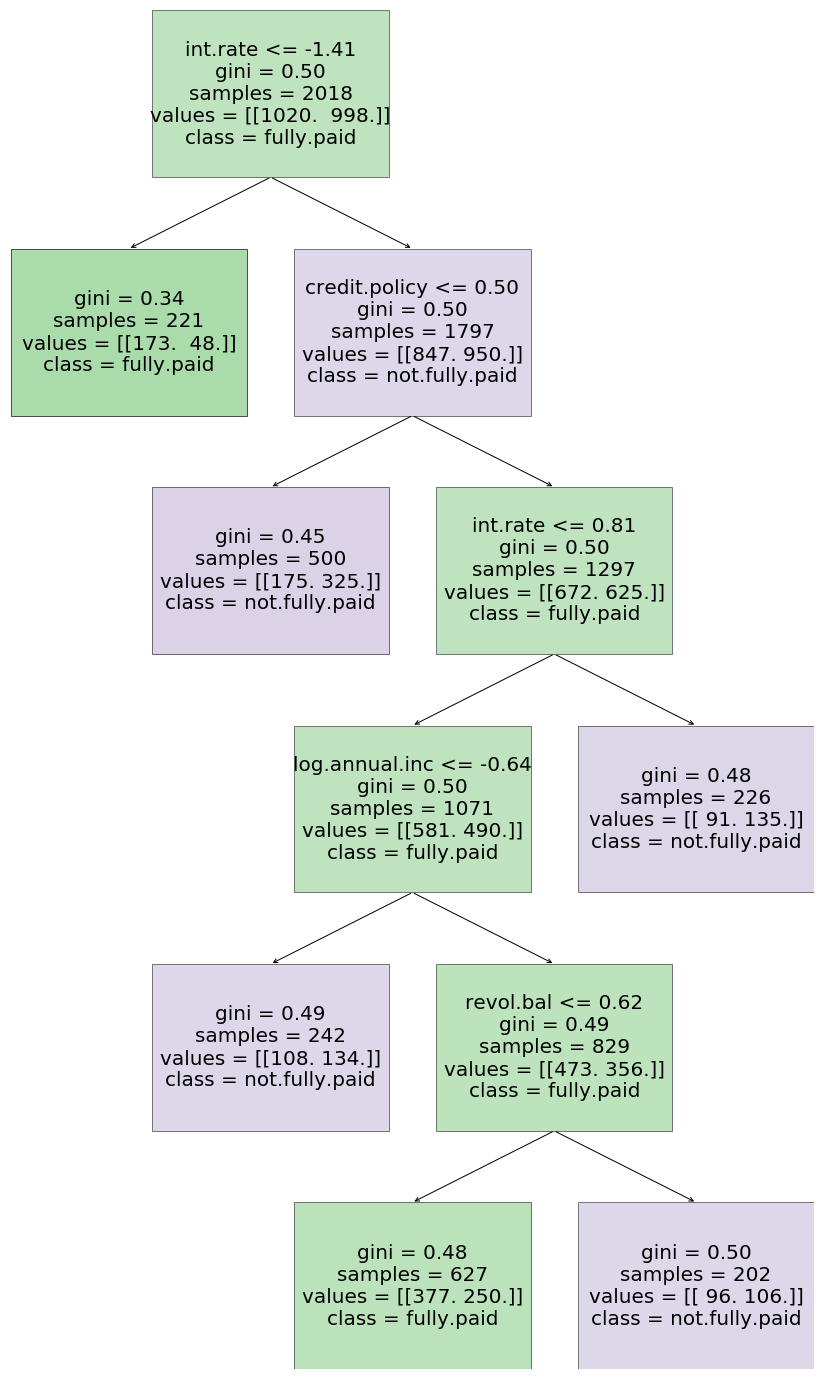

In [161]:
from sklearn.tree import DecisionTreeClassifier
from dtreeplt import dtreeplt

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=0.1,min_samples_split=0.4,random_state=1210)
dt.fit(X_train,y_train)

dtree = dtreeplt(
    model=dt,
    feature_names=list(X_train.columns),
    target_names=['fully.paid','not.fully.paid'])

fig = dtree.view()
fig.savefig('output.png')

### Decision Tree (before  PCA) is clearly the best model 
- Best F1 Score
- Best Score (Cross Validation)
- Easy to Interprete